In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import logging
import sys

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, median_absolute_error
import sqlalchemy as sa

import matplotlib
import matplotlib.pyplot as plt

import pudl
from pudl.output.pudltabl import PudlTabl
from pudl.metadata.fields import apply_pudl_dtypes
from pudl.metadata.dfs import POLITICAL_SUBDIVISIONS

In [4]:
from pudl.analysis.fuel_price import load_pudl_features, _add_features, FRCImputer, _cast_categorical, add_error_cols

In [5]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
census_engine = sa.create_engine(pudl_settings["censusdp1tract_db"])

# Notes
## FRC vs Bulk aggregate category harmonization
FRC fuel maps are slightly different from the ones we use with the bulk data; there is no `other_gas` category in the bulk aggs. They need to be harmonized for comparison.

FRC categories:

```
SELECT
    energy_source_code,
    fuel_group_code,
    count(*) as n
FROM fuel_receipts_costs_eia923
GROUP BY 1,2
ORDER BY 2,1
```

|energy_source_code|fuel_group_code|n|
|----|----|----|
|NULL|NULL|1|
|BIT|coal|132470|
|LIG|coal|3396|
|SC|coal|34|
|SUB|coal|75443|
|WC|coal|8109|
|NG|natural_gas|330786|
|BFG|other_gas|300|
|OG|other_gas|1477|
|PG|other_gas|122|
|SGP|other_gas|19|
|DFO|petroleum|46455|
|JF|petroleum|143|
|KER|petroleum|935|
|RFO|petroleum|5309|
|WO|petroleum|783|
|PC|petroleum_coke|2783|

Compare to the values present in the bulk aggregates:

```
SELECT fuel_agg, count(*) as n
FROM fuel_receipts_costs_aggs_eia
group by 1 order by 2 desc
```

|fuel_agg|n|
|----|----|
|natural_gas|124637|
|petroleum_liquids|99740|
|all_coal|93366|
|bituminous_coal|75573|
|sub_bituminous_coal|60149|
|petroleum_coke|35174|
|lignite_coal|11898|



# Data Preparation and Preprocessing

## Read data from PUDL DB and create some features 

In [7]:
%%time
frc = load_pudl_features(pudl_engine, census_engine)

CPU times: user 6.08 s, sys: 871 ms, total: 6.95 s
Wall time: 7.51 s


In [8]:
for date_col in ['report_date', 'contract_expiration_date', 'first_day_of_report_year']:
    frc.loc[:, date_col] = pd.to_datetime(frc.loc[:, date_col])

/tmp/ipykernel_13708/1425565854.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  frc.loc[:, date_col] = pd.to_datetime(frc.loc[:, date_col])
/tmp/ipykernel_13708/1425565854.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  frc.loc[:, date_col] = pd.to_datetime(frc.loc[:, date_col])
/tmp/ipykernel_13708/1425565854.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are no

In [9]:
frc = _add_features(frc)

2022-12-30 16:28:19 [    INFO] catalystcoop.pudl.helpers:202 Assigned state FIPS codes for 98.17% of records.
2022-12-30 16:28:26 [    INFO] catalystcoop.pudl.helpers:218 Assigned county FIPS codes for 94.84% of records.
/home/tpb/catalyst/pudl/src/pudl/analysis/fuel_price.py:404: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  out.loc[:, str_cols] = out.loc[:, str_cols].astype("object").replace(pd.NA, np.nan)
/home/tpb/catalyst/pudl/src/pudl/analysis/fuel_price.py:352: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, categorical_cols] = df.loc[

In [10]:
frc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608565 entries, 0 to 608564
Data columns (total 54 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   plant_id_eia                             608565 non-null  int64         
 1   report_date                              608565 non-null  datetime64[ns]
 2   contract_type_code                       608327 non-null  category      
 3   contract_expiration_date                 264263 non-null  datetime64[ns]
 4   energy_source_code                       608564 non-null  category      
 5   fuel_type_code_pudl                      608564 non-null  category      
 6   mine_id_pudl                             216618 non-null  float64       
 7   supplier_name                            608562 non-null  object        
 8   fuel_received_units                      608565 non-null  float64       
 9   fuel_mmbtu_per_unit       

In [11]:
feature_cols = [
# Categorical
    "energy_source_code",
    "contract_type_code",
    "primary_transportation_mode_code",
#    "natural_gas_delivery_contract_type_code",
    "natural_gas_transport_code",
    "mine_type_code",
   "mine_state",
#    "iso_rto_code",
#   "sector_name_eia",
#   "county_id_fips",
#   "mine_plant_same_state",  # bool
   "mine_plant_same_county", # bool
    "state",
#   "census_region",
   "secondary_transportation_mode_code",
#   "mine_county_id_fips",
   "fuel_group_code",
    
# Numerical
#   "mine_id_msha",
#   "latitude",
#   "longitude",
   "sulfur_content_pct",
   "ash_content_pct",
#   "moisture_content_pct",
#   "mercury_content_ppm",
#   "chlorine_content_ppm",
#   "remaining_contract_days",
#   "plant_id_eia", 
    "report_month",
    "elapsed_days",
   "fuel_received_mmbtu",
#   "fuel_cost_per_mmbtu",
   "fuel_mmbtu_per_unit",
#   "fuel_received_units",
]

In [12]:
imputer = FRCImputer(features=feature_cols, target_col='fuel_cost_per_mmbtu_clipped')

In [13]:
%%time
predicted = imputer.impute(frc)

CPU times: user 13min 55s, sys: 6.91 s, total: 14min 2s
Wall time: 1min 13s


In [14]:
# This is overfit due to no grouped validation set, but still useful for reference.
# Have to implement early stopping validation manually with a loop.
imputer.estimator['hist_gbr'].validation_score_[-1]

-0.2924598061512366

In [15]:
frc = pd.concat([frc, predicted], axis=1, copy=False)

In [16]:
add_error_cols(frc, target_col=imputer._target_col, prediction_col=imputer._target_col + "_imputed_values")

In [17]:
# training error
frc.loc[~imputer._to_impute, 'error'].abs().mean()

2.184443688791931

In [18]:
compare_cols = [imputer._target_col, imputer._target_col + "_imputed_values", 'fuel_received_mmbtu']
(frc.dropna(subset=compare_cols)
 .groupby('fuel_group_code')[compare_cols]
 .apply(lambda x: mean_absolute_percentage_error(y_true=x.loc[:, compare_cols[1]], # inverted pred/true to control outliers
                                                 y_pred=x.loc[:, compare_cols[0]],
                                                 sample_weight=x.loc[:, compare_cols[2]]
                                                 ) if x.shape[0] > 0 else np.nan
        )
)

fuel_group_code
coal              0.081873
natural_gas       0.124539
other_gas         0.220751
petroleum         0.074432
petroleum_coke    0.147942
dtype: float64

# External Validation
First make the reference datasets look like frc

In [20]:
from pudl.metadata.dfs import POLITICAL_SUBDIVISIONS

In [21]:
rename_dict = {
    'subdivision_code': 'state_abbrev',
    'subdivision_name': 'state_name',
    'division_code_us_census': 'census_region_abbrev',
    'division_name_us_census': 'region_name',
}
state_mappings = POLITICAL_SUBDIVISIONS.loc[POLITICAL_SUBDIVISIONS['country_code'].eq("USA"), rename_dict.keys()].rename(columns=rename_dict)
#state_mappings = pd.Series(STATE_TO_CENSUS_REGION, name='census_region_abbrev').to_frame().reset_index().rename(columns={'index': 'state_abbrev'})
#state_mappings['state_name'] = state_mappings['state_abbrev'].map(US_STATES_TERRITORIES)

In [23]:
census_names_map = {
    'ENC': 'East North Central',
    'ESC': 'East South Central',
    'MAT': 'Middle Atlantic',
    'MTN': 'Mountain',
    'NEW': 'New England',
    'PCC': 'Pacific Contiguous',
    'PCN': 'Pacific Noncontiguous',
    'SAT': 'South Atlantic',
    'WNC': 'West North Central',
    'WSC': 'West South Central',
}

In [24]:
state_mappings['region_name'] = state_mappings['census_region_abbrev'].map(census_names_map)

In [23]:
# drop territories
state_mappings = state_mappings.astype('category').dropna().reset_index()
state_mappings

,index,state_abbrev,state_name,census_region_abbrev,region_name
0,1,AK,Alaska,PCN,Pacific Noncontiguous
1,2,AL,Alabama,ESC,East South Central
2,3,AR,Arkansas,WSC,West South Central
3,5,AZ,Arizona,MTN,Mountain
4,7,CA,California,PCC,Pacific Contiguous
5,8,CO,Colorado,MTN,Mountain
6,9,CT,Connecticut,NEW,New England
7,10,DC,District of Columbia,SAT,South Atlantic
8,11,DE,Delaware,SAT,South Atlantic
9,12,FL,Florida,SAT,South Atlantic


### Get bulk aggregates

In [25]:
bulk = pd.read_sql_table(
    "fuel_receipts_costs_aggs_eia",
    pudl_engine,
)

In [26]:
bulk.head()

,fuel_agg,geo_agg,sector_agg,temporal_agg,report_date,fuel_received_mmbtu,fuel_cost_per_mmbtu
0,all_coal,AK,all_commercial,annual,2008-01-01,8656725.50,NaN
1,all_coal,AK,all_commercial,annual,2009-01-01,8389006.50,NaN
2,all_coal,AK,all_commercial,annual,2010-01-01,8919102.00,NaN
3,all_coal,AK,all_commercial,annual,2011-01-01,9808907.76,NaN
4,all_coal,AK,all_commercial,annual,2012-01-01,0.00,NaN


In [27]:
bulk.shape

(500537, 7)

In [29]:
frc.head()

,plant_id_eia,report_date,contract_type_code,contract_expiration_date,energy_source_code,fuel_type_code_pudl,mine_id_pudl,supplier_name,fuel_received_units,fuel_mmbtu_per_unit,sulfur_content_pct,ash_content_pct,mercury_content_ppm,primary_transportation_mode_code,secondary_transportation_mode_code,natural_gas_transport_code,natural_gas_delivery_contract_type_code,moisture_content_pct,chlorine_content_ppm,fuel_group_code,first_day_of_report_year,mine_name,mine_type_code,mine_id_msha,mine_county_id_fips,mine_state,latitude,longitude,state,county,ferc_cogen_status,ferc_exempt_wholesale_generator,ferc_small_power_producer,iso_rto_code,sector_name_eia,natural_gas_pipeline_name_1,natural_gas_pipeline_name_2,natural_gas_pipeline_name_3,regulatory_status_code,water_source,mine_longitude,mine_latitude,state_id_fips,county_id_fips,fuel_cost_per_mmbtu_clipped,fuel_cost_per_mmbtu_raw,elapsed_days,remaining_contract_days,report_month,census_region,fuel_received_mmbtu,mine_plant_same_state,mine_plant_same_county,mine_distance_km,fuel_cost_per_mmbtu_clipped_filled,fuel_cost_per_mmbtu_clipped_is_imputed,fuel_cost_per_mmbtu_clipped_imputed_values,error,rel_error
0,3,2008-01-01,C,2008-04-01,BIT,coal,0.0,interocean coal,259412.0,23.100,0.49,5.4,NaN,RV,NaN,firm,NaN,NaN,NaN,coal,2008-01-01,mina pribbenow,SU,NaN,NaN,COL,31.0069,-88.0103,AL,Mobile,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,RE,Mobile River,NaN,NaN,01,01097,2.135,2.135,0,91.0,1,ESC,5992417.200,False,False,NaN,2.135,False,2.146872,0.011872,0.005561
1,3,2008-01-01,C,2008-04-01,BIT,coal,0.0,interocean coal,52241.0,22.800,0.48,5.7,NaN,RV,NaN,firm,NaN,NaN,NaN,coal,2008-01-01,mina pribbenow,SU,NaN,NaN,COL,31.0069,-88.0103,AL,Mobile,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,RE,Mobile River,NaN,NaN,01,01097,2.115,2.115,0,91.0,1,ESC,1191094.800,False,False,NaN,2.115,False,2.237023,0.122023,0.057694
2,3,2008-01-01,C,NaT,NG,gas,NaN,bay gas pipeline,2783619.0,1.039,0.00,0.0,NaN,PL,NaN,firm,NaN,NaN,NaN,natural_gas,2008-01-01,NaN,NaN,NaN,NaN,NaN,31.0069,-88.0103,AL,Mobile,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,RE,Mobile River,NaN,NaN,01,01097,8.631,8.631,0,NaN,1,ESC,2892180.141,False,False,NaN,8.631,False,8.633169,0.002169,0.000251
3,7,2008-01-01,C,2015-12-01,BIT,coal,1.0,alabama coal,25397.0,24.610,1.69,14.7,NaN,TR,NaN,firm,NaN,NaN,NaN,coal,2008-01-01,alabama coal,SU,NaN,01007,AL,34.0128,-85.9708,AL,Etowah,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,RE,Coosa River,-87.127148,33.015893,01,01055,2.776,2.776,0,2891.0,1,ESC,625020.170,True,False,0.024204,2.776,False,2.667859,-0.108141,-0.038956
4,7,2008-01-01,S,2008-11-01,BIT,coal,2.0,d & e mining,764.0,24.446,0.84,15.5,NaN,TR,NaN,firm,NaN,NaN,NaN,coal,2008-01-01,flat rock 2,S,NaN,01145,AL,34.0128,-85.9708,AL,Etowah,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,RE,Coosa River,NaN,NaN,01,01055,3.381,3.381,0,305.0,1,ESC,18676.744,True,False,NaN,3.381,False,3.078581,-0.302419,-0.089447


In [30]:
# harmonize categories
frc['fuel_group_code_harmonized'] = frc.loc[:, 'fuel_group_code'].replace({'petroleum': 'petroleum_liquids', 'coal': 'all_coal'})

In [31]:
frc = (frc.merge(state_mappings.drop(columns='census_region_abbrev'), left_on='state', right_on='state_abbrev')
 .drop(columns='state_abbrev'))

In [33]:
frc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597400 entries, 0 to 597399
Data columns (total 63 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   plant_id_eia                                597400 non-null  int64         
 1   report_date                                 597400 non-null  datetime64[ns]
 2   contract_type_code                          597163 non-null  category      
 3   contract_expiration_date                    254912 non-null  datetime64[ns]
 4   energy_source_code                          597399 non-null  category      
 5   fuel_type_code_pudl                         597399 non-null  category      
 6   mine_id_pudl                                209040 non-null  float64       
 7   supplier_name                               597397 non-null  object        
 8   fuel_received_units                         597400 non-null  float64      

### Calculate EPM-style metrics
Drop C&I facilities and calculate Electric Sector fuel-weighted average price

In [34]:
def fuel_weighted_avg(df, col_to_avg: str):
    return (df[col_to_avg] * df['fuel_received_mmbtu']).sum() / df['fuel_received_mmbtu'].sum()

In [35]:
frc['sector_name_eia'].value_counts(dropna=False)

Electric Utility      362691
IPP Non-CHP            88085
NaN                    62612
IPP CHP                27004
IPP                    25259
Industrial CHP         21477
Industrial              8273
Commercial CHP          1143
Commercial               484
Industrial Non-CHP       372
Name: sector_name_eia, dtype: int64

In [36]:
frc['sector_name_eia'].value_counts(dropna=False, normalize=True)

Electric Utility      0.607116
IPP Non-CHP           0.147447
NaN                   0.104807
IPP CHP               0.045203
IPP                   0.042282
Industrial CHP        0.035951
Industrial            0.013848
Commercial CHP        0.001913
Commercial            0.000810
Industrial Non-CHP    0.000623
Name: sector_name_eia, dtype: float64

In [37]:
frc['year'] = frc['report_date'].dt.year

**Electric Power Sector, incl. NaN**

In [38]:
# including null sector
elec_sector = frc.loc[~frc['sector_name_eia'].str.contains('^Industrial|^Commercial', regex=True).fillna(False), :]
elec_sector.shape

(565651, 64)

In [39]:
state_grp = elec_sector.groupby(['state_name', 'fuel_group_code', 'report_date'])

In [40]:
valid_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_filled')
               .rename('frc_filled')
              ).to_frame()

In [41]:
meta_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_is_imputed')
              .rename('frac_fuel_imputed'))
model_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_imputed_values')
              .rename('frc_modeled'))

In [42]:
valid_state = valid_state.join([meta_state, model_state], how='left') # has all values

In [43]:
valid_state.head(3)

frc_filled  frac_fuel_imputed  frc_modeled
state_name fuel_group_code report_date                                            
Alabama    coal            2008-01-01     2.152864           0.006313     2.140941
                           2008-02-01     2.137206           0.007429     2.199021
                           2008-03-01     2.189903           0.004729     2.190596

In [33]:
state_epm = (eia_epm_state.set_index(['state_name', 'fuel_group_eiaepm', 'report_date']
                                    )['Electric Power Sector']
             .rename('power_sector_eia_epm')
            )

In [34]:
valid_state = valid_state.join(state_epm, how='outer')#.dropna(how='all')

In [35]:
valid_state['resid_filled'] = valid_state['power_sector_eia_epm'] - valid_state['frc_filled']
valid_state['rel_error_filled'] = valid_state['resid_filled'] / valid_state['power_sector_eia_epm']

In [36]:
util_ipp_nan = valid_state.copy()

**Electric Power Sector, NOT incl. NaN**

In [37]:
# NOT including null sector
elec_sector = frc.loc[~frc['sector_name_eia'].str.contains('^Industrial|^Commercial', regex=True).fillna(True), :]
elec_sector.shape

(499727, 57)

In [38]:
state_grp = elec_sector.groupby(['state_name', 'fuel_group_eiaepm', 'report_date'])

In [39]:
valid_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_filled')
               .rename('frc_filled')
              ).to_frame()

In [40]:
meta_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_is_imputed')
              .rename('frac_fuel_imputed'))
model_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_imputed_values')
              .rename('frc_modeled'))

In [41]:
valid_state = valid_state.join([meta_state, model_state], how='left') # has all values

In [42]:
state_epm = (eia_epm_state.set_index(['state_name', 'fuel_group_eiaepm', 'report_date']
                                    )['Electric Power Sector']
             .rename('power_sector_eia_epm')
            )

In [43]:
valid_state = valid_state.join(state_epm, how='outer')#.dropna(how='all')

In [44]:
valid_state['resid_filled'] = valid_state['power_sector_eia_epm'] - valid_state['frc_filled']
valid_state['rel_error_filled'] = valid_state['resid_filled'] / valid_state['power_sector_eia_epm']

In [45]:
util_ipp = valid_state.copy()

**Utilities only**

In [46]:
# utility only
elec_sector = frc.loc[frc['sector_name_eia'].eq('Electric Utility').fillna(False), :]
elec_sector.shape

(363010, 57)

In [47]:
state_grp = elec_sector.groupby(['state_name', 'fuel_group_eiaepm', 'report_date'])

In [48]:
valid_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_filled')
               .rename('frc_filled')
              ).to_frame()

In [49]:
meta_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_is_imputed')
              .rename('frac_fuel_imputed'))
model_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_imputed_values')
              .rename('frc_modeled'))

In [50]:
valid_state = valid_state.join([meta_state, model_state], how='left') # has all values

In [51]:
state_epm = (eia_epm_state.set_index(['state_name', 'fuel_group_eiaepm', 'report_date']
                                    )['Electric Utilities']
             .rename('utility_eia_epm')
            )

In [52]:
valid_state = valid_state.join(state_epm, how='outer')#.dropna(how='all')

In [53]:
valid_state['resid_filled'] = valid_state['utility_eia_epm'] - valid_state['frc_filled']
valid_state['rel_error_filled'] = valid_state['resid_filled'] / valid_state['utility_eia_epm']

In [54]:
util_only = valid_state.copy()

**Utilities w/ NaN**

In [55]:
elec_sector = frc.loc[frc['sector_name_eia'].str.startswith('Electric Utility').fillna(True), :]
elec_sector.shape

(391188, 57)

In [56]:
state_grp = elec_sector.groupby(['state_name', 'fuel_group_eiaepm', 'report_date'])

In [57]:
valid_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_filled')
               .rename('frc_filled')
              ).to_frame()

In [58]:
meta_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_is_imputed')
              .rename('frac_fuel_imputed'))
model_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_imputed_values')
              .rename('frc_modeled'))

In [59]:
valid_state = valid_state.join([meta_state, model_state], how='left') # has all values

In [60]:
state_epm = (eia_epm_state.set_index(['state_name', 'fuel_group_eiaepm', 'report_date']
                                    )['Electric Utilities']
             .rename('utility_eia_epm')
            )

In [61]:
valid_state = valid_state.join(state_epm, how='outer')#.dropna(how='all')

In [62]:
valid_state['resid_filled'] = valid_state['utility_eia_epm'] - valid_state['frc_filled']
valid_state['rel_error_filled'] = valid_state['resid_filled'] / valid_state['utility_eia_epm']

In [63]:
util_nan = valid_state.copy()

**IPP only**

In [64]:
# IPP only
elec_sector = frc.loc[frc['sector_name_eia'].str.startswith('IPP').fillna(False), :]
elec_sector.shape

(136717, 57)

In [65]:
state_grp = elec_sector.groupby(['state_name', 'fuel_group_eiaepm', 'report_date'])

In [66]:
valid_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_filled')
               .rename('frc_filled')
              ).to_frame()

In [67]:
meta_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_is_imputed')
              .rename('frac_fuel_imputed'))
model_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_imputed_values')
              .rename('frc_modeled'))

In [68]:
valid_state = valid_state.join([meta_state, model_state], how='left') # has all values

In [69]:
state_epm = (eia_epm_state.set_index(['state_name', 'fuel_group_eiaepm', 'report_date']
                                    )['Independent Power Producers']
             .rename('ipp_eia_epm')
            )

In [70]:
valid_state = valid_state.join(state_epm, how='outer')#.dropna(how='all')

In [71]:
valid_state['resid_filled'] = valid_state['ipp_eia_epm'] - valid_state['frc_filled']
valid_state['rel_error_filled'] = valid_state['resid_filled'] / valid_state['ipp_eia_epm']

In [72]:
ipp_only = valid_state.copy()

**All**

In [114]:
state_grp = frc.groupby(['state_name', 'fuel_group_eiaepm', 'report_date'])

In [115]:
valid_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_filled')
               .rename('frc_filled')
              ).to_frame()

In [116]:
meta_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_is_imputed')
              .rename('frac_fuel_imputed'))
model_state = (state_grp.apply(fuel_weighted_avg, col_to_avg=imputer._target_col + '_imputed_values')
              .rename('frc_modeled'))

In [117]:
valid_state = valid_state.join([meta_state, model_state], how='left') # has all values

In [118]:
state_epm = (eia_epm_state.set_index(['state_name', 'fuel_group_eiaepm', 'report_date']
                                    )['Electric Power Sector']
             .rename('power_sector_eia_epm')
            )

In [119]:
valid_state = valid_state.join(state_epm, how='outer')#.dropna(how='all')

In [122]:
valid_state['resid_filled'] = valid_state['power_sector_eia_epm'] - valid_state['frc_filled']
valid_state['rel_error_filled'] = valid_state['resid_filled'] / valid_state['power_sector_eia_epm']

In [123]:
all_frc = valid_state.copy()

### Reverse Engineering the EPM metric
Where there are no imputations at all, can we reporoduce the EPM numbers? Need to get this dialed in first. Ideas:
* check sector categories
    * include NaN sectors?
    * try to reproduce utilities first because few NaN
* add clipped values back in

#### Conclusions
It looks like fuel-weighted average price is the right metric: looking only at Electric Power Sector state-months with zero missing data, 72% are within the numerical precision of EIA's numbers (my standard for "exactly correct"). Including NaN sectors into Electric Power reduces error.

But there are two weird things:
1. Whole power sector accuracy looks better than utililty-only accuracy, despite utilities being almost the only ones reporting to FRC.
1. The residuals are biased towards FRC *over*estimating relative to EIA EPM, which I don't understand. This is especially prominent in in the utlity-only comparison. The known biases are in the opposite direction: clipping high prices or mistakenly excluding  plants by sector should both produce *under*estimates.

Gas and oil have by far the worst error for some reason. Because gas is cheaper it has a much worse percentage error.

In [73]:
def error_metrics(df, y_pred:str='frc_filled', y_true:str='power_sector_eia_epm'):
    no_nan = df.dropna(subset=[y_pred, y_true])
    out = {}    
    for err_func in [mean_absolute_error, mean_squared_error, median_absolute_error, mean_absolute_percentage_error]:
        out[err_func.__name__] = err_func(y_true=no_nan.loc[:, y_true], y_pred=no_nan.loc[:, y_pred])
    out['count'] = no_nan.shape[0]
    out['count_within_precision'] = no_nan['resid_filled'].abs().le(0.005).sum()
    out['frac_within_precision'] = out['count_within_precision'] / out['count']
    return out

In [74]:
def error_metrics_by_fuel(df, y_pred:str='frc_filled', y_true:str='power_sector_eia_epm', tol=0.005):
    no_nan = df.dropna(subset=[y_pred, y_true]).copy()
    no_nan['resid'] = no_nan.loc[:, y_true] - no_nan.loc[:, y_pred]
    grp = no_nan.groupby('fuel_group_eiaepm')
    metric_series = []
    for err_func in [mean_absolute_error, mean_squared_error, median_absolute_error, mean_absolute_percentage_error]:
        name = ''.join([word[0] if (word != 'median') else 'med_' for word in err_func.__name__.split('_')])
        e = grp[[y_pred, y_true]].apply(lambda x: err_func(y_true=x.loc[:, y_true],
                                         y_pred=x.loc[:, y_pred],
                                         ) if x.shape[0] > 0 else np.nan
                      ).rename(name)
        metric_series.append(e)
    n = grp.size().rename('n_samples')
    n_exact = grp['resid'].apply(lambda x: x.abs().le(tol).sum()).rename('n_exact')
    bias = grp['resid'].agg(['mean', 'median']).rename(columns={'mean': 'mean_bias', 'median': 'median_bias'})
    frac_exact = n_exact.div(n).rename('frac_exact')
    
    out = pd.concat(metric_series + [n, n_exact, frac_exact, bias], axis=1)
    return out

#### Utilities, no NaN

In [75]:
zero_imputation = util_only.loc[util_only['frac_fuel_imputed'].eq(0),:]

<AxesSubplot:xlabel='utility_eia_epm', ylabel='frc_filled'>

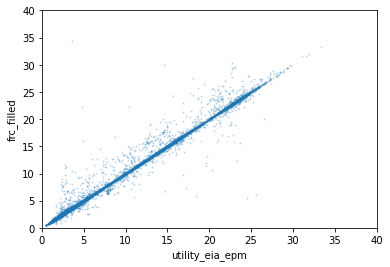

In [76]:
zero_imputation.plot.scatter(x='utility_eia_epm', y='frc_filled', s=1, alpha=0.2, xlim=(0,40), ylim=(0,40))

In [77]:
error_metrics(zero_imputation, y_true='utility_eia_epm')

{'mean_absolute_error': 0.18142310600358139,
 'mean_squared_error': 8.115818307653393,
 'median_absolute_error': 0.004005572531533108,
 'mean_absolute_percentage_error': 0.024199428341166368,
 'count': 15847,
 'count_within_precision': 9579,
 'frac_within_precision': 0.604467722597337}

In [78]:
error_metrics_by_fuel(zero_imputation, y_true='utility_eia_epm')

,mae,mse,med_ae,mape,n_samples,n_exact,frac_exact,mean_bias,median_bias
fuel_group_eiaepm,,,,,,,,,
coal,0.032714,0.054559,0.003498,0.014475,5263,3709,0.704731,-0.021333,-0.000454
natural_gas,0.255786,24.690531,0.004740,0.039807,5027,2652,0.527551,0.022511,-0.000683
petroleum,0.287053,0.868995,0.004567,0.019013,4822,2609,0.541062,-0.144516,0.000000
petroleum_coke,0.044668,0.019915,0.003000,0.021107,735,609,0.828571,-0.031328,-0.000103


In [79]:
pd.cut(zero_imputation['resid_filled'], bins=[-np.inf, -0.005, 0.005, np.inf]).value_counts()

(-0.005, 0.005]    9579
(-inf, -0.005]     3656
(0.005, inf]       2612
Name: resid_filled, dtype: int64

#### Utilities, w/ NaN

In [80]:
zero_imputation = util_nan.loc[util_nan['frac_fuel_imputed'].eq(0),:]

<AxesSubplot:xlabel='utility_eia_epm', ylabel='frc_filled'>

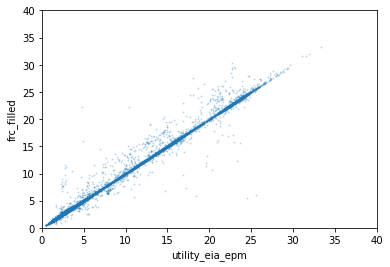

In [81]:
zero_imputation.plot.scatter(x='utility_eia_epm', y='frc_filled',s=1, alpha=0.2, xlim=(0,40), ylim=(0,40))

In [82]:
error_metrics(zero_imputation, y_true='utility_eia_epm')

{'mean_absolute_error': 0.17165844846329542,
 'mean_squared_error': 9.290968097807683,
 'median_absolute_error': 0.003689574967820519,
 'mean_absolute_percentage_error': 0.019881931216097763,
 'count': 13591,
 'count_within_precision': 9038,
 'frac_within_precision': 0.6649988963284527}

In [83]:
error_metrics_by_fuel(zero_imputation, y_true='utility_eia_epm')

,mae,mse,med_ae,mape,n_samples,n_exact,frac_exact,mean_bias,median_bias
fuel_group_eiaepm,,,,,,,,,
coal,0.026513,0.058672,0.003169,0.011677,4657,3547,0.761649,-0.018244,-0.000354
natural_gas,0.259652,31.752527,0.004068,0.031676,3852,2359,0.612409,0.082462,-0.000235
petroleum,0.270653,0.845396,0.004099,0.018014,4347,2523,0.580400,-0.161517,-0.000143
petroleum_coke,0.044668,0.019915,0.003000,0.021107,735,609,0.828571,-0.031328,-0.000103


In [84]:
pd.cut(zero_imputation['resid_filled'], bins=[-np.inf, -0.005, 0.005, np.inf]).value_counts()

(-0.005, 0.005]    9038
(-inf, -0.005]     2709
(0.005, inf]       1844
Name: resid_filled, dtype: int64

#### Electricity Sector, w/ NaN

In [85]:
zero_imputation = util_ipp_nan.loc[util_ipp_nan['frac_fuel_imputed'].eq(0),:]

<AxesSubplot:xlabel='power_sector_eia_epm', ylabel='frc_filled'>

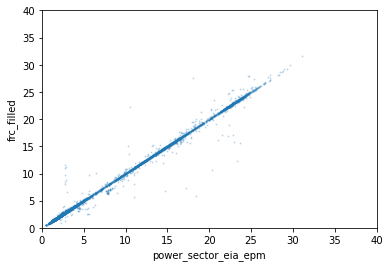

In [86]:
zero_imputation.plot.scatter(x='power_sector_eia_epm', y='frc_filled', s=1, alpha=0.2, xlim=(0,40), ylim=(0,40))

In [87]:
error_metrics(zero_imputation, y_true='power_sector_eia_epm')

{'mean_absolute_error': 0.08211922151630524,
 'mean_squared_error': 0.25719861375543523,
 'median_absolute_error': 0.0033182647260954212,
 'mean_absolute_percentage_error': 0.012617436076091386,
 'count': 7101,
 'count_within_precision': 5128,
 'frac_within_precision': 0.722151809604281}

In [88]:
error_metrics_by_fuel(zero_imputation, y_true='power_sector_eia_epm')

,mae,mse,med_ae,mape,n_samples,n_exact,frac_exact,mean_bias,median_bias
fuel_group_eiaepm,,,,,,,,,
coal,0.009369,0.000835,0.003038,0.004390,2576,2053,0.796972,-0.005107,-0.000513
natural_gas,0.206815,0.808441,0.004000,0.043245,1119,699,0.624665,0.042967,-0.000092
petroleum,0.111183,0.336212,0.003660,0.006659,2702,1787,0.661362,-0.002276,0.000000
petroleum_coke,0.038568,0.015806,0.003000,0.016908,704,589,0.836648,-0.035298,-0.000479


In [89]:
pd.cut(zero_imputation['resid_filled'], bins=[-np.inf, -0.005, 0.005, np.inf]).value_counts()

(-0.005, 0.005]    5128
(-inf, -0.005]     1182
(0.005, inf]        791
Name: resid_filled, dtype: int64

#### Electricity Sector, w/OUT NaN

In [90]:
zero_imputation = util_ipp.loc[util_ipp['frac_fuel_imputed'].eq(0),:]

<AxesSubplot:xlabel='power_sector_eia_epm', ylabel='frc_filled'>

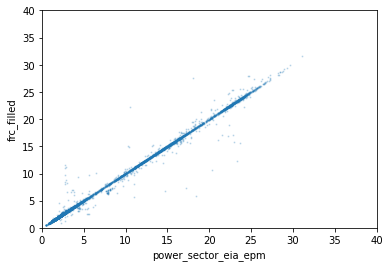

In [91]:
zero_imputation.plot.scatter(x='power_sector_eia_epm', y='frc_filled', s=1, alpha=0.2, xlim=(0,40), ylim=(0,40))

In [92]:
error_metrics(zero_imputation, y_true='power_sector_eia_epm')

{'mean_absolute_error': 0.08617481103434173,
 'mean_squared_error': 0.26869692533834444,
 'median_absolute_error': 0.0034370313016567344,
 'mean_absolute_percentage_error': 0.01384071431004326,
 'count': 7253,
 'count_within_precision': 5098,
 'frac_within_precision': 0.7028815662484489}

In [93]:
error_metrics_by_fuel(zero_imputation, y_true='power_sector_eia_epm')

,mae,mse,med_ae,mape,n_samples,n_exact,frac_exact,mean_bias,median_bias
fuel_group_eiaepm,,,,,,,,,
coal,0.009449,0.000841,0.003041,0.004425,2632,2102,0.798632,-0.005208,-0.000520
natural_gas,0.233060,0.895496,0.004600,0.051327,1145,623,0.544105,0.014352,-0.000426
petroleum,0.110444,0.328346,0.003831,0.006518,2772,1784,0.643579,0.000540,0.000000
petroleum_coke,0.038568,0.015806,0.003000,0.016908,704,589,0.836648,-0.035298,-0.000479


In [94]:
pd.cut(zero_imputation['resid_filled'], bins=[-np.inf, -0.005, 0.005, np.inf]).value_counts()

(-0.005, 0.005]    5098
(-inf, -0.005]     1286
(0.005, inf]        869
Name: resid_filled, dtype: int64

#### All

In [132]:
zero_imputation = all_frc.loc[all_frc['frac_fuel_imputed'].eq(0),:]

<AxesSubplot:xlabel='power_sector_eia_epm', ylabel='frc_filled'>

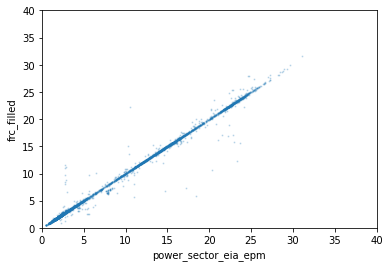

In [133]:
zero_imputation.plot.scatter(x='power_sector_eia_epm', y='frc_filled', s=1, alpha=0.2, xlim=(0,40), ylim=(0,40))

In [134]:
error_metrics(zero_imputation, y_true='power_sector_eia_epm')

{'mean_absolute_error': 0.09804830658570789,
 'mean_squared_error': 0.3303041105656209,
 'median_absolute_error': 0.0032746616988510446,
 'mean_absolute_percentage_error': 0.0150547282028877,
 'count': 5097,
 'count_within_precision': 3680,
 'frac_within_precision': 0.7219933294094566}

In [127]:
error_metrics_by_fuel(zero_imputation, y_true='power_sector_eia_epm')

,mae,mse,med_ae,mape,n_samples,n_exact,frac_exact,mean_bias,median_bias
fuel_group_eiaepm,,,,,,,,,
coal,0.007210,0.000463,0.002946,0.003543,1570,1300,0.828025,-0.002116,-0.000254
natural_gas,0.289737,1.199781,0.004129,0.059988,749,439,0.586115,0.063753,0.000544
petroleum,0.111249,0.351557,0.003562,0.006618,2199,1470,0.668486,0.004388,0.000000
petroleum_coke,0.046255,0.019211,0.003000,0.020184,579,471,0.813472,-0.043161,-0.000818


In [128]:
pd.cut(zero_imputation['resid_filled'], bins=[-np.inf, -0.005, 0.005, np.inf]).value_counts()

(-0.005, 0.005]    3680
(-inf, -0.005]      797
(0.005, inf]        620
Name: resid_filled, dtype: int64

## Imputation Validation

### Electricity Sector, w/ NaN
This sector had the lowest error.

#### Baseline: look at performance on training data

In [95]:
training_results = util_ipp_nan.loc[util_ipp_nan['frac_fuel_imputed'].eq(0),:]

<AxesSubplot:xlabel='power_sector_eia_epm', ylabel='frc_modeled'>

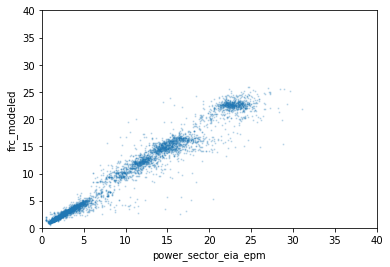

In [96]:
training_results.plot.scatter(x='power_sector_eia_epm', y='frc_modeled',
                          s=1, alpha=0.2, xlim=(0,40), ylim=(0,40))

In [97]:
error_metrics(training_results, y_pred='frc_modeled', y_true='power_sector_eia_epm')

{'mean_absolute_error': 0.6123743210353962,
 'mean_squared_error': 1.551484157602862,
 'median_absolute_error': 0.1936485827781631,
 'mean_absolute_percentage_error': 0.07824656156219889,
 'count': 7101,
 'count_within_precision': 5128,
 'frac_within_precision': 0.722151809604281}

In [98]:
error_metrics_by_fuel(training_results, y_pred='frc_modeled', y_true='power_sector_eia_epm')

,mae,mse,med_ae,mape,n_samples,n_exact,frac_exact,mean_bias,median_bias
fuel_group_eiaepm,,,,,,,,,
coal,0.078294,0.091796,0.042671,0.032480,2576,188,0.072981,0.021807,0.003829
natural_gas,0.744265,2.319272,0.357852,0.140247,1119,11,0.009830,0.552389,0.211328
petroleum,1.169073,3.000954,0.807598,0.075452,2702,14,0.005181,0.224018,-0.009542
petroleum_coke,0.220340,0.109060,0.132600,0.157887,704,32,0.045455,-0.053305,-0.027913


### Moment of Truth: Test Data
#### Pure Imputation
NOTE: This is regionally concentrated in state-month-fuel groups with all IPP plants.

In [99]:
pure_imputations = util_ipp_nan.loc[util_ipp_nan['frac_fuel_imputed'].eq(1),:]

<AxesSubplot:xlabel='power_sector_eia_epm', ylabel='frc_modeled'>

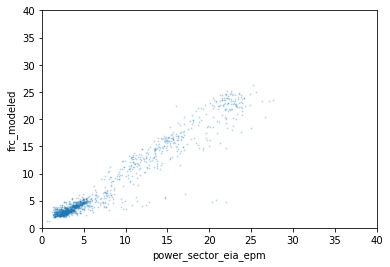

In [100]:
pure_imputations.plot.scatter(x='power_sector_eia_epm', y='frc_modeled',
                          s=1, alpha=0.2, xlim=(0,40), ylim=(0,40))

In [101]:
error_metrics(pure_imputations, y_pred='frc_modeled', y_true='power_sector_eia_epm')

{'mean_absolute_error': 0.9361450792608745,
 'mean_squared_error': 2.676825621797633,
 'median_absolute_error': 0.48961582682522575,
 'mean_absolute_percentage_error': 0.16886857802270558,
 'count': 1367,
 'count_within_precision': 5,
 'frac_within_precision': 0.0036576444769568397}

In [102]:
error_metrics_by_fuel(pure_imputations, y_pred='frc_modeled', y_true='power_sector_eia_epm')

,mae,mse,med_ae,mape,n_samples,n_exact,frac_exact,mean_bias,median_bias
fuel_group_eiaepm,,,,,,,,,
coal,0.264247,0.132076,0.209118,0.091116,369,3,0.008130,0.033498,-0.014905
natural_gas,0.995900,3.634629,0.549728,0.226020,611,2,0.003273,0.346209,-0.039682
petroleum,1.531446,3.838145,1.283456,0.096176,345,0,0.000000,-0.276193,-0.654295
petroleum_coke,1.079989,1.561101,1.032316,0.617682,42,0,0.000000,-1.079989,-1.032316


#### Mixed Imputation

In [135]:
mixed_imputations = util_ipp_nan.loc[util_ipp_nan['frac_fuel_imputed'].gt(0) & util_ipp_nan['frac_fuel_imputed'].lt(1),:]

<AxesSubplot:xlabel='power_sector_eia_epm', ylabel='frc_modeled'>

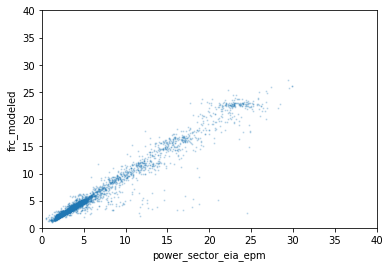

In [136]:
mixed_imputations.plot.scatter(x='power_sector_eia_epm', y='frc_modeled',
                          s=1, alpha=0.2, xlim=(0,40), ylim=(0,40))

In [137]:
error_metrics(mixed_imputations, y_pred='frc_modeled', y_true='power_sector_eia_epm')

{'mean_absolute_error': 0.5489022793271499,
 'mean_squared_error': 1.9045999899754695,
 'median_absolute_error': 0.19507984671317669,
 'mean_absolute_percentage_error': 0.08535926493614365,
 'count': 4145,
 'count_within_precision': 251,
 'frac_within_precision': 0.060554885404101325}

In [138]:
error_metrics_by_fuel(mixed_imputations, y_pred='frc_modeled', y_true='power_sector_eia_epm')

,mae,mse,med_ae,mape,n_samples,n_exact,frac_exact,mean_bias,median_bias
fuel_group_eiaepm,,,,,,,,,
coal,0.124797,0.036086,0.072173,0.059718,976,44,0.045082,-0.038166,-0.011812
natural_gas,0.510064,2.176381,0.204164,0.097066,2524,52,0.020602,0.206853,0.000783
petroleum,1.342632,3.668466,0.949243,0.078348,645,2,0.003101,0.583547,0.309938


In [144]:
#util_ipp_nan.to_csv('/mnt/c/Users/tpbus/Downloads/util_ipp_nan.csv', index=True)

In [140]:
util_ipp_nan.head(3)

frc_filled  frac_fuel_imputed  frc_modeled  power_sector_eia_epm  resid_filled  rel_error_filled
state_name fuel_group_eiaepm report_date                                                                                                  
Alabama    coal              2006-09-01          NaN                NaN          NaN                  2.11           NaN               NaN
                             2006-10-01          NaN                NaN          NaN                  2.35           NaN               NaN
                             2006-11-01          NaN                NaN          NaN                  2.14           NaN               NaN

In [ ]:
raise ValueError

<AxesSubplot:xlabel='power_sector_eia_epm', ylabel='frc_filled'>

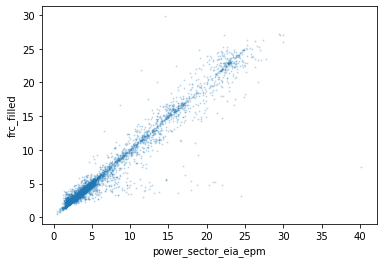

In [165]:
valid_state.loc[valid_state['frac_fuel_imputed'].ne(0),:].plot.scatter(x='power_sector_eia_epm', y='frc_filled', s=1, alpha=0.2)

<AxesSubplot:>

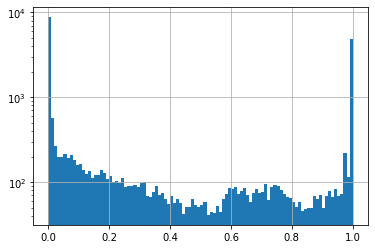

In [93]:
valid_state['frac_fuel_imputed'].hist(bins=100, log=True)

In [94]:
valid_state['frac_fuel_imputed'].eq(0).mean(), valid_state['frac_fuel_imputed'].eq(1).mean()

(0.2203143957377222, 0.1171862636493116)

<AxesSubplot:>

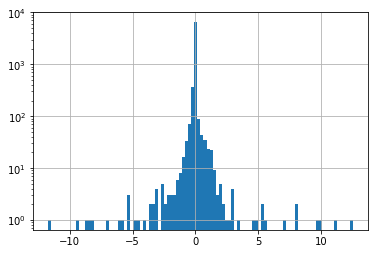

In [167]:
valid_state.loc[valid_state['frac_fuel_imputed'].eq(0), 'resid_filled'].hist(bins=100, log=True)

<AxesSubplot:>

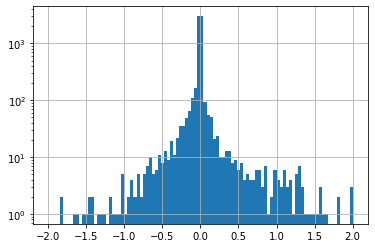

In [110]:
valid_state.loc[valid_state['frac_fuel_imputed'].eq(0), 'resid_filled'].hist(bins=100, log=True, range=(-2,2))

In [126]:
valid_state.loc[valid_state['frac_fuel_imputed'].eq(0), 'resid_filled'].count()

7101

<AxesSubplot:>

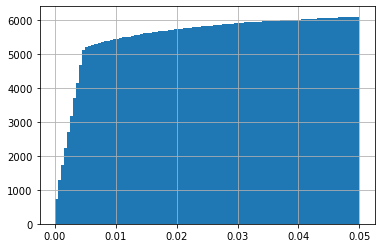

In [130]:
# 5/7 thousand are within the precision of the EPM data (+-0.005)
valid_state.loc[valid_state['frac_fuel_imputed'].eq(0), 'resid_filled'].abs().hist(bins=100, cumulative=True, log=False, density=False, range=(0,0.05))

In [134]:
filter_ = (valid_state['frac_fuel_imputed'].eq(0) &  # no imputation
          valid_state['resid_filled'].abs().gt(0.005)  # error not within numerical precision
          )
bad = valid_state.loc[filter_, :]

In [135]:
bad.shape

(1973, 6)

In [142]:
bad['abs_error'] = bad['resid_filled'].abs()

/tmp/ipykernel_25986/2595326004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad['abs_error'] = bad['resid_filled'].abs()


In [145]:
bad.groupby('state_name')['abs_error'].sum().nlargest(10)

state_name
North Dakota      108.374361
Alaska             80.249960
Colorado           60.700714
South Dakota       53.771847
Florida            34.571687
Nebraska           30.477151
Kentucky           27.423667
Kansas             20.972561
South Carolina     20.159991
Wyoming            17.281445
Name: abs_error, dtype: float64

In [146]:
bad.groupby('fuel_group_eiaepm')['abs_error'].sum().nlargest(10)

fuel_group_eiaepm
petroleum         296.457349
natural_gas       229.676790
petroleum_coke     25.790159
coal               19.127793
Name: abs_error, dtype: float64

In [148]:
valid_state.loc[valid_state.loc[valid_state['frac_fuel_imputed'].eq(0), 'resid_filled'].abs().nlargest(20).index,:]

frc_filled  frac_fuel_imputed  frc_modeled  power_sector_eia_epm  resid_filled  rel_error_filled
state_name   fuel_group_eiaepm report_date                                                                                                  
South Dakota natural_gas       2008-03-01     5.939996                0.0     8.514067                 18.47     12.530004          0.678398
             petroleum         2008-01-01    22.202127                0.0    17.674435                 10.49    -11.712127         -1.116504
Colorado     petroleum         2012-09-01    12.226000                0.0    17.474198                 23.33     11.104000          0.475954
North Dakota natural_gas       2018-02-01     7.308713                0.0     3.086860                 17.20      9.891287          0.575075
Colorado     petroleum         2012-06-01    10.570000                0.0    16.656179                 20.35      9.780000          0.480590
California   petroleum         2010-09-01    27.510000                0.0    14.432997                 18.07     -9.440000         -0.522413
North Dakota natural_gas       2015-01-01    11.599433                0.0     3.338166                  2.81     -8.789433         -3.127912
                               2015-05-01    11.089361                0.0     3.059288                  2.76     -8.329361         -3.017884
                               2015-07-01    11.151601                0.0     3.491690                  2.92     -8.231601         -2.819041
Colorado     petroleum         2012-04-01    15.570000                0.0    17.338123                 23.73      8.160000          0.343869
North Dakota natural_gas       2018-01-01     6.793237                0.0     3.491100                 14.76      7.966763          0.539754
Colorado     petroleum         2011-04-01    15.873516                0.0    18.801484                 23.01      7.136484          0.310147
North Dakota natural_gas       2015-03-01     9.769928                0.0     3.515634                  2.73     -7.039928         -2.578728
                               2015-02-01     8.835071                0.0     3.778222                  2.93     -5.905071         -2.015383
                               2015-06-01     8.423168                0.0     3.386297                  2.71     -5.713168         -2.108180
Colorado     petroleum         2012-02-01    17.163000                0.0    17.556023                 22.87      5.707000          0.249541
                               2012-03-01    16.830000                0.0    17.357220                 22.19      5.360000          0.241550
South Dakota natural_gas       2008-01-01     5.686319                0.0     7.406258                 10.95      5.263681          0.480701
North Dakota natural_gas       2015-04-01     7.990890                0.0     3.137823                  2.76     -5.230890         -1.895250
Kentucky     petroleum         2010-07-01    16.149893                0.0    16.113818                 21.05      4.900107          0.232784

In [149]:
filter_ = (
    elec_sector['state_name'].eq('Colorado') & 
    elec_sector['fuel_group_eiaepm'].eq('petroleum') & 
    elec_sector['report_date'].eq('2012-09-01')
    )
elec_sector.loc[filter_,:]

,report_date,plant_id_eia,contract_type_code,contract_expiration_date,energy_source_code,fuel_type_code_pudl,mine_id_pudl,supplier_name,fuel_received_units,fuel_mmbtu_per_unit,sulfur_content_pct,ash_content_pct,mercury_content_ppm,primary_transportation_mode_code,secondary_transportation_mode_code,natural_gas_transport_code,natural_gas_delivery_contract_type_code,moisture_content_pct,chlorine_content_ppm,mine_name,mine_type_code,mine_county_id_fips,mine_state,fuel_group_eiaepm,ferc_cogen_status,ferc_exempt_wholesale_generator,ferc_small_power_producer,iso_rto_code,latitude,longitude,state,county,sector_name_eia,natural_gas_pipeline_name_1,natural_gas_pipeline_name_2,natural_gas_pipeline_name_3,regulatory_status_code,water_source,state_id_fips,county_id_fips,fuel_cost_per_mmbtu_clipped,fuel_cost_per_mmbtu_raw,elapsed_days,remaining_contract_days,report_month,census_region,fuel_received_mmbtu,mine_plant_same_state,mine_plant_same_county,fuel_cost_per_mmbtu_clipped_filled,fuel_cost_per_mmbtu_clipped_is_imputed,fuel_cost_per_mmbtu_clipped_imputed_values,error,rel_error,state_name,region_name
263685,2012-09-01,527,S,NaT,WO,oil,NaN,westland propane,228.0,3.85,0.0,0.0,0.0,TR,NaN,interruptible,NaN,NaN,NaN,None,NaN,NaN,NaN,petroleum,0.0,0.0,0.0,NaN,38.2383,-108.5069,CO,Montrose,Electric Utility,None,NaN,NaN,RE,San Miguel River,08,08085,12.226,12.226,1705,NaN,9,MTN,877.8,False,False,12.226,False,17.474198,5.248198,0.429265,Colorado,Mountain
